## A demo performing the interpretability of C-PLANK

Example of the interaction between RAB14 and FFF004, which has been validated by refer [1]

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from Prediction.screening import screening
from Prediction.utils import *
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from itertools import product
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image

In [2]:
def standardize_smi(sml):
    mol = Chem.MolFromSmiles(sml)
    try: clean_mol = rdMolStandardize.Cleanup(mol)
    except: clean_mol = mol
    stan_smiles = Chem.MolToSmiles(clean_mol, canonical=True)
    
    return stan_smiles

In [3]:
file_path = './Data'
ligand_repo = pd.read_csv(os.path.join(file_path, 'ligand_repository.tsv'), sep='\t')
ligand_repo = {x['fragId']:x['SMILES'] for x in ligand_repo.to_dict("records")}
protein_repo = pd.read_csv(os.path.join(file_path, 'protein_repository.tsv'), sep='\t')
prot2gene = {x['Entry']:x['Gene Names'] for x in protein_repo.to_dict("records")}
prot2seq = {x['Entry']:x['Sequence'] for x in protein_repo.to_dict("records")}
gene2prot = {gene:prot for prot,gene in prot2gene.items()}
sc = screening(file_path)

In [4]:
gene = 'RAB14'
sml = 'C#CCCC1(N=N1)CCNC(C2(CC2)C3=CC(OC(F)(F)O4)=C4C=C3)=O'
sml = standardize_smi(sml)
result = sc.given_pair_screen(prot=gene, ligand=sml)
result

[16:33:36] Initializing MetalDisconnector
[16:33:36] Running MetalDisconnector
[16:33:36] Initializing Normalizer
[16:33:36] Running Normalizer
[16:33:36] Initializing MetalDisconnector
[16:33:36] Running MetalDisconnector
[16:33:36] Initializing Normalizer
[16:33:36] Running Normalizer


{'Pair score': 0.7303061,
 'Diazo score': array(0.04275001, dtype=float32),
 'Diazo position': [4, 24, 25],
 'Alkyne score': array(0.03006819, dtype=float32),
 'Alkyne position': [0, 1, 2, 3],
 'Fragment score': array(0.03955143, dtype=float32)}

### Read in attention score to visulize the importance of atoms and residues

In [8]:
residue_score = pd.read_csv(os.path.join(file_path, f'screening_result/{gene}_LigandA_residue_score.csv'))
atom_score = pd.read_csv(os.path.join(file_path, f'screening_result/{gene}_LigandA_atom_score.csv'))
cols_drop = residue_score.columns[(residue_score == 0).any()]
residue_score = residue_score.drop(columns=cols_drop)
cols_drop = atom_score.columns[(atom_score == 0).any()]
atom_score = atom_score.drop(columns=cols_drop)

scaler = MinMaxScaler()
atom_score = scaler.fit_transform(atom_score.values[0].reshape(-1, 1))

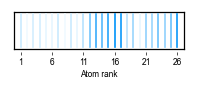

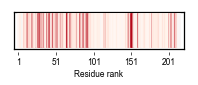

In [7]:
striped_heatmap(atom_score.T, 'Atom rank', interval=5, fff=True, save=False)
striped_heatmap(residue_score.values, 'Residue rank', 50, expand=4, save=False)

### Mapping atom importance to ligand structue

In [28]:
def colormap(atom2score):
    scores = np.array(list(atom2score.values()))
    norm = Normalize(vmin=np.min(scores), vmax=np.max(scores))
    colors_hex = ['#f0faff','#0094fa']
    cmap_name = 'my_list'
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors_hex, N=len(scores))

    sm = ScalarMappable(norm=norm, cmap=cmap)
    atom2color = {atom:sm.to_rgba(score) for atom, score in atom2score.items()}

    return atom2color, sm

def ligand_visual(mol, atom2score):
    atom2color, sm = colormap(atom2score)
    
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    options = drawer.drawOptions()
    options.highlightRadius = 0.3
    drawer.DrawMolecule(mol, highlightAtoms=list(atom2color.keys()), 
                        highlightAtomColors=atom2color,
                        )
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(img_data))
    
    fig, ax = plt.subplots(figsize=(4, 4),dpi=60)
    plt.rcParams['font.sans-serif'] = 'Arial'
    ax.imshow(img)
    ax.axis('off')
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.05, aspect=10, pad=0.1,
                        orientation='vertical')
    cbar.set_label('Nomalized\natom attention score', 
                   rotation=90, labelpad=10, fontsize=14)
    cbar.set_ticks([0, 0.5, 1])
    cbar.ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.show()

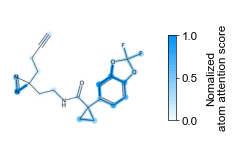

In [29]:
mol = Chem.MolFromSmiles(sml)
AllChem.Compute2DCoords(mol)
atom2score = {i:score[0] for i, score in enumerate(atom_score)}
ligand_visual(mol, atom2score)

### Mapping residue importance to protein structure

The visualization of residue importance is achieved using PyMOL which is a tool to visualize protein 3D structure, with following step:
1. Transferring the normalized attention score into a color code for each residue in order (see ./Prediction/colormapping.py)
2. Running the color mapping code on PyMOL (see ./Prediction/pymol_script.py)

### Reference
[1] Wozniak, J. M. et al. Enhanced mapping of small-molecule binding sites in cells. Nature Chemical Biology 20, 823-834 (2024).